<a href="https://colab.research.google.com/github/sehoonyoon/Test/blob/main/5_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


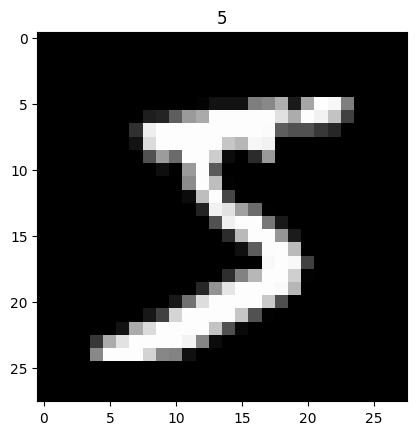

(60000, 784) (10000, 784)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, t_train),(x_test,t_test) = mnist.load_data()    # MNIST 읽어 들이기
print(x_train.shape,x_test.shape)   # 28x28의 손으로 쓴 문자 이미지가 6만장

# 각 필셀의 값을 -1에서 1의 범위에 넣는다
x_train = x_train / 255 * 2 - 1
x_test = x_test / 255 * 2 - 1

# 손으로 쓴 문자 이미지의 표시
plt.imshow(x_train[0].reshape(28,28),cmap="gray")
plt.title(t_train[0])
plt.show()

# 1차원으로 변환한다
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)
print(x_train.shape,x_test.shape)

In [ ]:
n_learn = 20001 # 학습 횟수
interval = 2000 # 이미지를 생성하는 간격
batch_size = 32
n_noize = 128 # 노이지의 수
img_size = 28 # 생성되는 이미지의 높이와 폭
alpha = 0.2 # Leaky ReLU의 음의 영역에서의 기울기

from tensorflow.python.keras.optimizers import adam_v2
optimizer = adam_v2.Adam(0.002, 0.5)

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LeakyReLU

# Genenrator의 망 구축
generator = Sequential()
generator.add(Dense(256, input_shape=(n_noize,)))
generator.add(LeakyReLU(alpha=alpha))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=alpha))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=alpha))
generator.add(Dense(img_size**2,activation="tanh"))
print(generator . summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [ ]:

# Discriminator의 망 구축
discriminator = Sequential()
discriminator.add(Dense(512, input_shape=(img_size**2,)))
discriminator.add(LeakyReLU(alpha=alpha))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=alpha))
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
print(discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input

# 결합 사는 Generator만 훈련한다
discriminator.trainable = False

# Generator에 의해 노이즈로부터 생성된 이미지를 Discriminator가 판정한다
noise = Input(shape=(n_noize,))
img = generator(noise)
reality = discriminator(img)

# Generator와 Discriminator의 결합
combined = Model(noise, reality)
combined.compile(loss="binary_crossentropy" , optimizer=optimizer)
print(combined.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1493520   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,493,520
Non-trainable params: 533,505
_________________________________________________________________
None


In [ ]:
def generate_images(i):
    n_rows = 5    # 행 수
    n_cols = 5    # 열 수
    noise = np.random.normal(0,1, (n_rows*n_cols, n_noize))
    g_imgs = generator.predict(noise)
    g_imgs = g_imgs/2 + 0.5   # 0-1의 범위로 한다

    matrix_image = np.zeros((img_size*n_rows, img_size*n_cols))   # 전체의 이미지

    # 생성된 이미지를 나열해 1장의 이미지로 한다
    for r in range(n_rows):
        for c in range(n_cols):
            g_img = g_imgs[r*n_cols + c].reshape(img_size, img_size)
            matrix_image[r*img_size : (r+1)*img_size, c*img_size: (c+1)*img_size] = g_img

    plt.figure(figsize=(10,10))
    plt.imshow(matrix_image, cmap="Greys_r")
    plt.tick_params(labelbottom=False, labelleft=False,bottom=False, left=False)    # 축 눈금의 라벨과 선을 지운다
    plt.show()

n_learn: 0
loss_fake: 0.6672244071960449 acc_fake: 0.75
loss_real: 4.393840789794922 acc_real: 0.0
loss_comb: 2.932199001312256
n_learn: 2000
loss_fake: 5.868358812222141e-07 acc_fake: 1.0
loss_real: 1.103625137943709e-07 acc_real: 1.0
loss_comb: 14.350717544555664
n_learn: 4000
loss_fake: 2.7554800908546895e-05 acc_fake: 1.0
loss_real: 5.185003101360053e-05 acc_real: 1.0
loss_comb: 10.610681533813477
n_learn: 6000
loss_fake: 7.942560387164121e-07 acc_fake: 1.0
loss_real: 9.54025949795323e-07 acc_real: 1.0
loss_comb: 14.07365608215332
n_learn: 8000
loss_fake: 6.218505888000436e-08 acc_fake: 1.0
loss_real: 2.9681248747692734e-07 acc_real: 1.0
loss_comb: 16.594388961791992
n_learn: 10000
loss_fake: 6.819539703428745e-05 acc_fake: 1.0
loss_real: 3.041435411432758e-05 acc_real: 1.0
loss_comb: 14.108298301696777
n_learn: 12000
loss_fake: 0.0 acc_fake: 1.0
loss_real: 0.0 acc_real: 1.0
loss_comb: 278.247802734375
n_learn: 14000
loss_fake: 1.695613475521576e-22 acc_fake: 1.0
loss_real: 2.75473

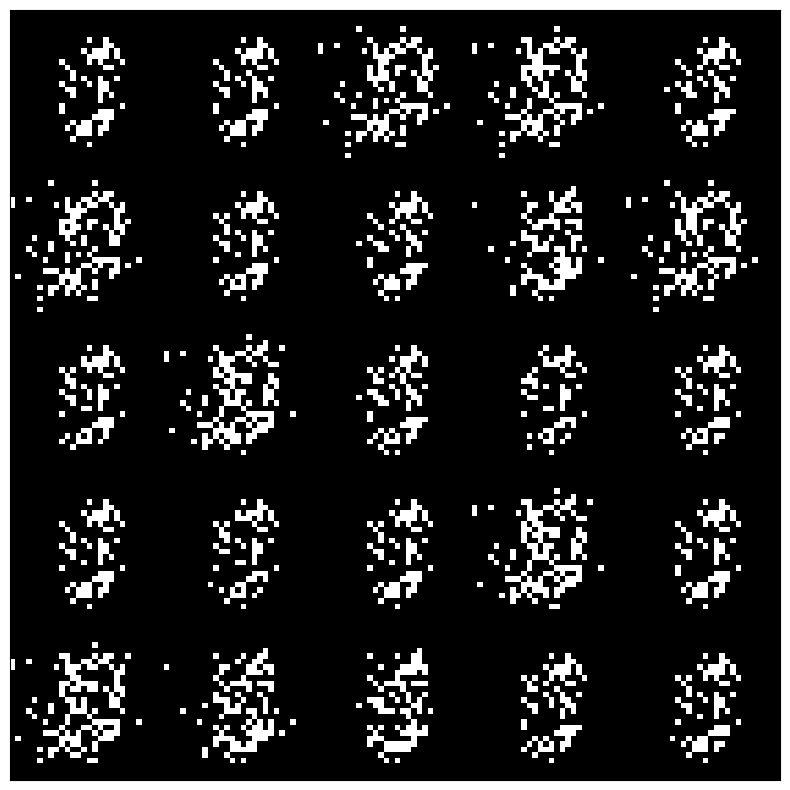

In [ ]:
batch_half = batch_size // 2

loss_record = np.zeros((n_learn, 3))
acc_record = np.zeros((n_learn, 2))

for i in range(n_learn):

 # 노이즈로부터 이미지를 생성해 Discriminator를 훈현
    g_noise = np.random.normal(0,1, (batch_half, n_noize))
    g_imgs = generator.predict(g_noise)
    loss_fake, acc_fake = discriminator.train_on_batch(g_imgs,np.zeros((batch_half,1)))
    loss_record[i][0] = loss_fake
    acc_record[i][0] = acc_fake

    # 진짜 이미지를 사용해서 Discriminator를 훈련
    rand_ids = np.random.randint(len(x_train), size=batch_half)
    real_imgs = x_train[rand_ids, :]
    loss_real, acc_real = discriminator.train_on_batch(real_imgs, np.ones((batch_half,1)))
    loss_record[i][1] = loss_real
    acc_record[i][1] = acc_real

    # 결합한 모델에 의해 Generator를 훈련
    c_noise = np.random.normal(0,1,(batch_size, n_noize))
    loss_comb = combined.train_on_batch(c_noise, np.ones((batch_size, 1)))
    loss_record[i][2] = loss_comb

    # 일정 간격으로 생성된 이미지를 표시
    if i % interval ==0:
        print("n_learn:", i)
        print("loss_fake:", loss_fake, "acc_fake:", acc_fake)
        print("loss_real:", loss_real, "acc_real:", acc_real)
        print("loss_comb:", loss_comb)

generate_images(i)

